# Track filtering/fitting with LSTMs and Gaussian predictions

This is a continuous space model using the ACTS data.
Like the LSTMTrackFilter notebook, it predicts the location of the next hit given a hit sequence.
However, unlike the previous model, we now produce a probability distribution in the form of a multivariate Gaussian.

This lets our model quantify uncertainty and score hits in a more meaningful way.

In [1]:
# Select a GPU first
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '6'
cuda = False

In [2]:
from __future__ import print_function

# System imports
import ast
import multiprocessing as mp
from timeit import default_timer as timer

# Data libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Torch imports
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

# Visualization
import matplotlib.pyplot as plt

# Local imports
from data import load_data_events

# Magic
%matplotlib notebook

## Utilities

In [3]:
def process_hits_data(df, copy_keys=['evtid', 'barcode', 'volid', 'layid']):
    """Split columns and calculate some derived variables"""
    x = df.gpos.apply(lambda pos: pos[0])
    y = df.gpos.apply(lambda pos: pos[1])
    z = df.gpos.apply(lambda pos: pos[2])
    r = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return df[copy_keys].assign(z=z.astype(np.float32), r=r.astype(np.float32),
                                phi=phi.astype(np.float32))

def read_worker(hits_file):
    hits_columns = ['hitid', 'barcode', 'volid', 'layid', 'lpos',
                    'lerr', 'gpos', 'chans', 'dir', 'direrr']
    return process_hits_data(load_data_events(hits_file, columns=hits_columns))

def process_files(hits_files, num_workers):
    """Load and process a set of hits files with MP"""
    pool = mp.Pool(processes=num_workers)
    hits = pool.map(read_worker, hits_files)
    pool.close()
    pool.join()
    # Fix the evtid to be consecutive
    for i in range(1, len(hits)):
        hits[i].evtid += hits[i-1].evtid.iloc[-1] + 1
    return pd.concat(hits, ignore_index=True)

In [4]:
def select_hits(hits):
    # Select all barrel hits
    vids = [8, 13, 17]
    barrel_hits = hits[np.logical_or.reduce([hits.volid == v for v in vids])]
    # Re-enumerate the volume and layer numbers for convenience
    volume = pd.Series(-1, index=barrel_hits.index, dtype=np.int8)
    vid_groups = barrel_hits.groupby('volid')
    for i, v in enumerate(vids):
        volume[vid_groups.get_group(v).index] = i
    # This assumes 4 layers per volume (except last volume)
    layer = (barrel_hits.layid / 2 - 1 + volume * 4).astype(np.int8)
    return (barrel_hits[['evtid', 'barcode', 'phi', 'z']]
            .assign(volume=volume, layer=layer))

def select_signal_hits(hits):
    """Select signal hits from tracks that hit all barrel layers"""
    return (hits.groupby(['evtid', 'barcode'])
            # Select tracks that hit every layer at least once
            .filter(lambda x: len(x) >= 10 and x.layer.unique().size == 10)
            # Average duplicate hits together
            .groupby(['evtid', 'barcode', 'layer'], as_index=False).mean())

## Read the data

In [5]:
data_dir = '/global/cscratch1/sd/sfarrell/ACTS/prod_mu10_pt1000_2017_07_29'

In [6]:
n_files = 5

all_files = os.listdir(data_dir)
hits_files = sorted(f for f in all_files if f.startswith('clusters'))
hits_files = [os.path.join(data_dir, f) for f in hits_files[:n_files]]

In [7]:
n_workers = 5
hits = process_files(hits_files, num_workers=n_workers)

Loading /global/cscratch1/sd/sfarrell/ACTS/prod_mu10_pt1000_2017_07_29/clusters_1.csv
Loading /global/cscratch1/sd/sfarrell/ACTS/prod_mu10_pt1000_2017_07_29/clusters_10.csv
Loading /global/cscratch1/sd/sfarrell/ACTS/prod_mu10_pt1000_2017_07_29/clusters_11.csv
Loading /global/cscratch1/sd/sfarrell/ACTS/prod_mu10_pt1000_2017_07_29/clusters_12.csv
Loading /global/cscratch1/sd/sfarrell/ACTS/prod_mu10_pt1000_2017_07_29/clusters_100.csv


In [8]:
print('Hits data shape:', hits.shape)

Hits data shape: (2628605, 7)


In [9]:
%%time

# Select hits
selected_hits = select_hits(hits)
print('selected barrel hits:', selected_hits.shape)
signal_hits = select_signal_hits(selected_hits)
print('signal track hits:', signal_hits.shape)

selected barrel hits: (1655325, 6)
signal track hits: (680960, 6)
CPU times: user 34.7 s, sys: 456 ms, total: 35.2 s
Wall time: 35.2 s


In [10]:
%%time

# Gather features into tensor of shape (events, layers, features)
input_data = np.stack(signal_hits.groupby(['evtid', 'barcode'])
                      .apply(lambda x: x[['phi', 'z', 'layer']].values)).astype(np.float32)

# Scale coordinates to approx [-1, 1] for phi and z, [0, 1] for layer number
coord_scale = np.array([np.pi, 1000., 10.])
input_data[:,:] /= coord_scale

CPU times: user 33.6 s, sys: 154 ms, total: 33.8 s
Wall time: 33.8 s


In [11]:
# Scale coordinates to approximately [-1, 1] for phi, z and [0, 1] for layer
coord_scale = np.array([np.pi, 1000., 10.])

In [12]:
input_data.shape

(68096, 10, 3)

## Define the model

We define an LSTM model in PyTorch which will predict the next hit location.

In [13]:
# CUDA memory allocations
if cuda:
    np_to_torch = lambda x: Variable(torch.from_numpy(x)).cuda()
    create_tensor_var = lambda *size: Variable(torch.cuda.FloatTensor(*size).zero_())
else:
    np_to_torch = lambda x: Variable(torch.from_numpy(x))
    create_tensor_var = lambda *size: Variable(torch.FloatTensor(*size).zero_())

In [14]:
class Cholesky(torch.autograd.Function):
    """
    Cholesky decomposition with gradient. Taken from
    https://github.com/t-vi/pytorch-tvmisc/blob/master/misc/gaussian_process_regression_basic.ipynb
    """
    @staticmethod
    def forward(ctx, a):
        l = torch.potrf(a, False)
        ctx.save_for_backward(l)
        return l

    @staticmethod
    def backward(ctx, grad_output):
        l, = ctx.saved_variables
        # Gradient is l^{-H} @ ((l^{H} @ grad) * (tril(ones)-1/2*eye)) @ l^{-1}
        # Ideally, this should use some form of solve triangular instead of inverse...
        linv =  l.inverse()
        
        inner = (torch.tril(torch.mm(l.t(), grad_output)) * 
                 torch.tril(1.0 - Variable(l.data.new(l.size(1)).fill_(0.5).diag())))
        s = torch.mm(linv.t(), torch.mm(inner, linv))
        return s

In [15]:
class TrackFilterer(nn.Module):
    """
    A PyTorch module for particle track state estimation and hit prediction.
    
    This module is an RNN which takes a sequence of hits and produces a
    Gaussian shaped prediction for the location of the next hit.
    """
    
    def __init__(self, hidden_dim=5):
        super(TrackFilterer, self).__init__()
        input_dim = 3
        output_dim = 2
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        out_size = input_dim * (input_dim + 3) / 2
        self.fc = nn.Linear(hidden_dim, out_size)
        
    def forward(self, x):
        """Might want to accept also the radius of the target layer."""
        input_size = x.size()
        
        # Initialize the LSTM hidden state
        h = (create_tensor_var(input_size[0], self.lstm.hidden_size),
             create_tensor_var(input_size[0], self.lstm.hidden_size))
        # Apply the LSTM module
        x, h = self.lstm(x, h)
        # Squash layer axis into batch axis
        x = x.contiguous().view(-1, x.size(-1))
        # Apply linear layer
        output = self.fc(x)
        # Expand the axis layer again (maybe not, for now)
        #x = x.view(input_size[0], input_size[1], -1)
        
        # Extract and transform the gaussian parameters
        means = output[:, :2]
        variances = output[:, 2:4].exp()
        correlations = output[:, 4].tanh()
        
        # Construct the covariance matrix
        covs = torch.bmm(variances[:, :, None], variances[:, None, :]).sqrt()
        covs[:, 0, 1] = covs[:, 0, 1].clone() * correlations
        covs[:, 1, 0] = covs[:, 1, 0].clone() * correlations
        
        # Expand the layer axis again, just for consistency/interpretability
        means = means.contiguous().view(input_size[0], input_size[1], 2)
        covs = covs.contiguous().view(input_size[0], input_size[1], 2, 2)
        return means, covs

In [17]:
def prepare_model_data(data):
    """
    Put a chunk of numpy data into format for the model.
    Reshapes and slices out the input and target features,
    and converts into PyTorch Variable format.    
    """
    # All but last detector layer used as inputs
    inputs = np_to_torch(data[:, :-1])
    # Target includes all but first layer, and drops the layer feature
    targets = np_to_torch(data[:, 1:, :-1])
    return inputs, targets

In [16]:
def gaus_llh_loss(outputs, targets):
    """Custom gaussian log-likelihood loss function"""
    means, covs = outputs
    # Flatten layer axis into batch axis to use batch matrix operations
    means = means.contiguous().view(means.size(0)*means.size(1), means.size(2))
    covs = covs.contiguous().view(covs.size(0)*covs.size(1), covs.size(2), covs.size(3))
    targets = targets.contiguous().view(targets.size(0)*targets.size(1), targets.size(2))
    # Calculate the inverses of the covariance matrices
    inv_covs = torch.stack([cov.inverse() for cov in covs])
    # Calculate the residual error
    #print(targets.size(), means.size(), inv_covs.size())
    res = targets - means
    # Calculate the residual error term
    res_right = torch.bmm(inv_covs, res.unsqueeze(-1)).squeeze(-1)
    res_term = torch.bmm(res[:,None,:], res_right[:,:,None]).squeeze()
    # For the determinant term, we first have to compute the cholesky roots
    diag_chols = torch.stack([Cholesky.apply(cov).diag() for cov in covs])
    log_det = diag_chols.log().sum(1) * 2
    gllh_loss = (res_term + log_det).sum()
    return gllh_loss

### Instantiate a model and test it on a small set of data

## Configure and train the model

In [18]:
def training_step(model, inputs, targets, loss_func, optimizer):
    model.zero_grad()
    outputs = model(inputs)
    loss = loss_func(outputs, targets)
    loss.backward()
    optimizer.step()
    return loss

In [136]:
# Model config
hidden_dim = 10

# Train config
n_epochs = 10
batch_size = 32
test_frac = 0.1

In [20]:
# Split data into training, validation, and test sets
train_data, test_data = train_test_split(input_data, test_size=test_frac)

In [32]:
train_input, train_target = prepare_model_data(train_data)
test_input, test_target = prepare_model_data(test_data)

n_samples = train_input.size(0)
n_batches = (n_samples + batch_size - 1) // batch_size
print('Training samples:', n_samples)
print('Batches per epoch:', n_batches)
print('Test samples:', test_input.size(0))

Training samples: 61286
Batches per epoch: 1916
Test samples: 6810


In [137]:
# Construct the model
model = TrackFilterer(hidden_dim=hidden_dim)
if cuda:
    model.cuda()
optimizer = torch.optim.Adam(model.parameters())
loss_func = gaus_llh_loss

print(model)
print('Parameters:', sum(param.numel() for param in model.parameters()))

TrackFilterer (
  (lstm): LSTM(3, 10, batch_first=True)
  (fc): Linear (10 -> 9)
)
Parameters: 699


In [ ]:
batch_idxs = np.arange(0, n_samples, batch_size)
train_losses, valid_losses = [], []

for i in range(n_epochs):
    print('Epoch', i)
    start_time = timer()
    sum_loss = 0

    for j in batch_idxs:
        batch_input = train_input[j:j+batch_size]
        batch_target = train_target[j:j+batch_size]
        loss = training_step(model, batch_input, batch_target, loss_func, optimizer)
        sum_loss += loss.cpu().data[0]
        #sum_loss += training_step(model, batch_input, batch_target, loss_func, optimizer)

    end_time = timer()
    avg_loss = sum_loss / n_batches
    #avg_loss = sum_loss.cpu().data[0] / n_batches
    train_losses.append(avg_loss)
    print('  training loss %.3g' % avg_loss, 'time %gs' % (end_time - start_time))
    
    # Evaluate the model on the validation set
    valid_loss = loss_func(model(test_input), test_target).cpu().data[0]
    valid_losses.append(valid_loss)
    print('  validate loss %.3g' % valid_loss)

Epoch 0
  training loss -2.03e+03 time 188.174s
  validate loss -5.83e+05
Epoch 1
  training loss -3.12e+03 time 182.328s
  validate loss -7.33e+05
Epoch 2
  training loss -3.73e+03 time 182.436s
  validate loss -8.19e+05
Epoch 3
  training loss -3.98e+03 time 178.031s
  validate loss -8.47e+05
Epoch 4


In [143]:
train_losses

[-2032.5301759253277,
 -3121.8119764228454,
 -3733.376903621538,
 -3979.2309551836306,
 -4122.735594269627,
 -4208.5469071740645,
 -4269.837406803521,
 -4320.958341148552,
 -4365.273541794938,
 -4403.544632499552]

In [144]:
valid_losses

[-582923.25,
 -733165.6875,
 -819445.8125,
 -846919.875,
 -885317.875,
 -903763.125,
 -913305.5625,
 -919318.375,
 -928206.5625,
 -936812.8125]

<IPython.core.display.Javascript object>


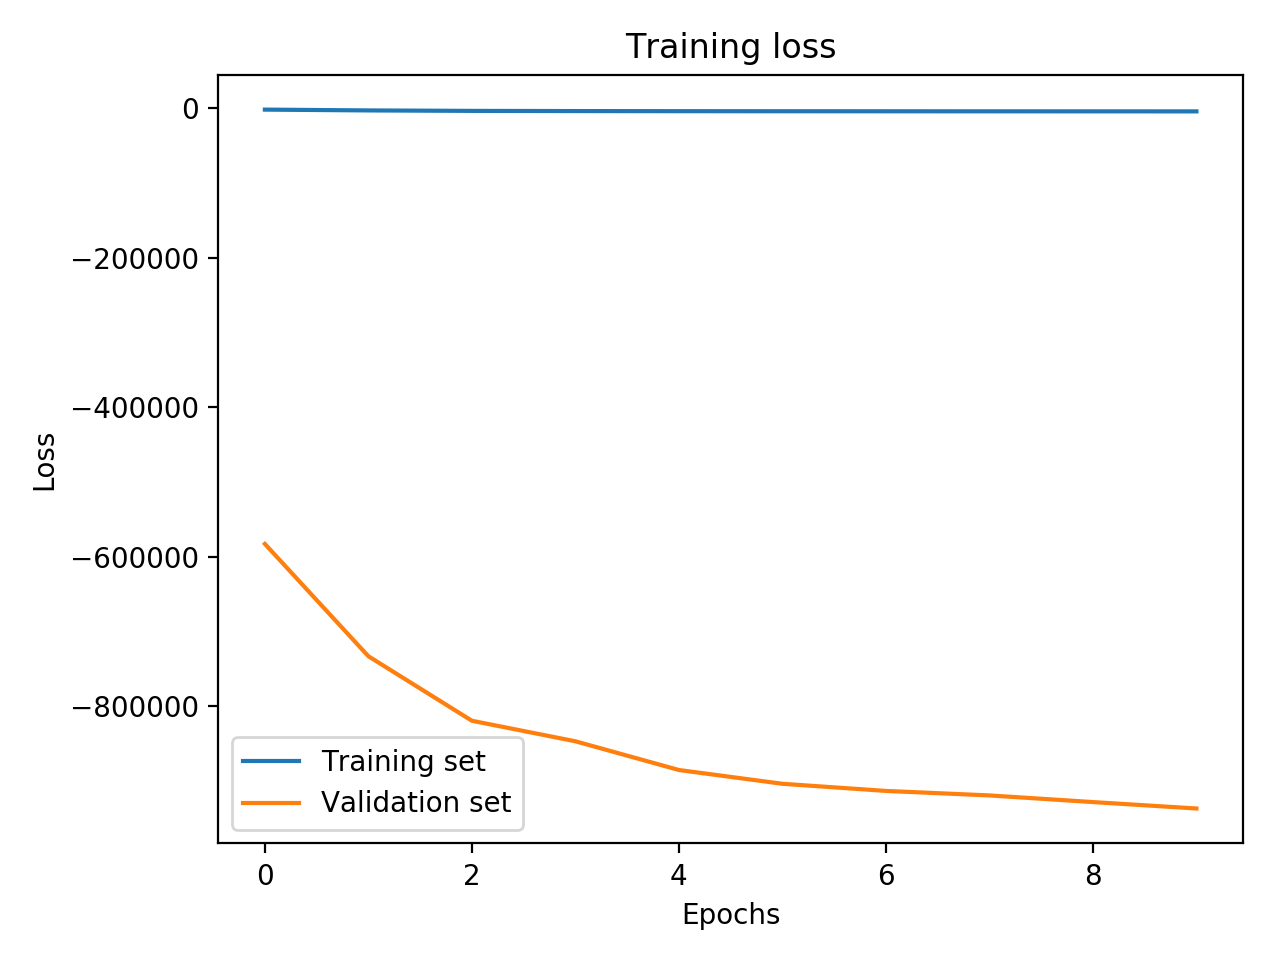

In [142]:
plt.figure()
epochs = np.arange(n_epochs)
plt.plot(epochs, np.array(train_losses), label='Training set')
plt.plot(epochs, np.array(valid_losses), label='Validation set')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training loss')
plt.legend(loc=0)
plt.tight_layout()

## Evaluate model performance

Understanding the loss is a bit difficult. I need to provide some additional metrics.

In [35]:
test_output = model(test_input)
test_variances = torch.stack([test_output[1][:, :, 0, 0], test_output[1][:, :, 1, 1]], dim=-1)
len(test_output), test_output[0].size(), test_output[1].size()

(2, torch.Size([6810, 9, 2]), torch.Size([6810, 9, 2, 2]))

In [36]:
i = 1
print('Input:', test_input[i])
print('Target:', test_target[i])
print('Means:', test_output[0][i])
print('Residual:', test_target[i] - test_output[0][i])
print('ModelSigma:', test_variances[i].sqrt())

Input: Variable containing:
-0.0402  0.0165  0.0000
-0.0375  0.0409  0.1000
-0.0348  0.0673  0.2000
-0.0313  0.1010  0.3000
-0.0260  0.1545  0.4000
-0.0199  0.2180  0.5000
-0.0115  0.2970  0.6000
-0.0015  0.4000  0.7000
 0.0079  0.5150  0.8000
[torch.FloatTensor of size 9x3]

Target: Variable containing:
-0.0375  0.0409
-0.0348  0.0673
-0.0313  0.1010
-0.0260  0.1545
-0.0199  0.2180
-0.0115  0.2970
-0.0015  0.4000
 0.0079  0.5150
 0.0204  0.6180
[torch.FloatTensor of size 9x2]

Means: Variable containing:
-0.0679  0.0226
-0.0260  0.0442
-0.0418  0.0939
-0.0301  0.1343
-0.0236  0.2096
-0.0191  0.2897
-0.0099  0.3899
-0.0019  0.5174
 0.0026  0.6476
[torch.FloatTensor of size 9x2]

Residual: Variable containing:
1.00000e-02 *
  3.0429  1.8293
 -0.8785  2.3033
  1.0405  0.7135
  0.4123  2.0202
  0.3744  0.8439
  0.7531  0.7284
  0.8428  1.0055
  0.9814 -0.2421
  1.7794 -2.9610
[torch.FloatTensor of size 9x2]

ModelSigma: Variable containing:
 0.1839  0.1235
 0.0605  0.0446
 0.0334  0.0294


### Drawing Gaussians

Let's develop some visualization code.

In [57]:
import scipy.stats

In [147]:
# Pick out the values to draw
isample = 6
mus = test_output[0][isample].data.numpy()
covs = test_output[1][isample].data.numpy()
targets = test_target[isample].data.numpy()

lay = test_input[isample, 1:, 2].data.numpy()

<IPython.core.display.Javascript object>


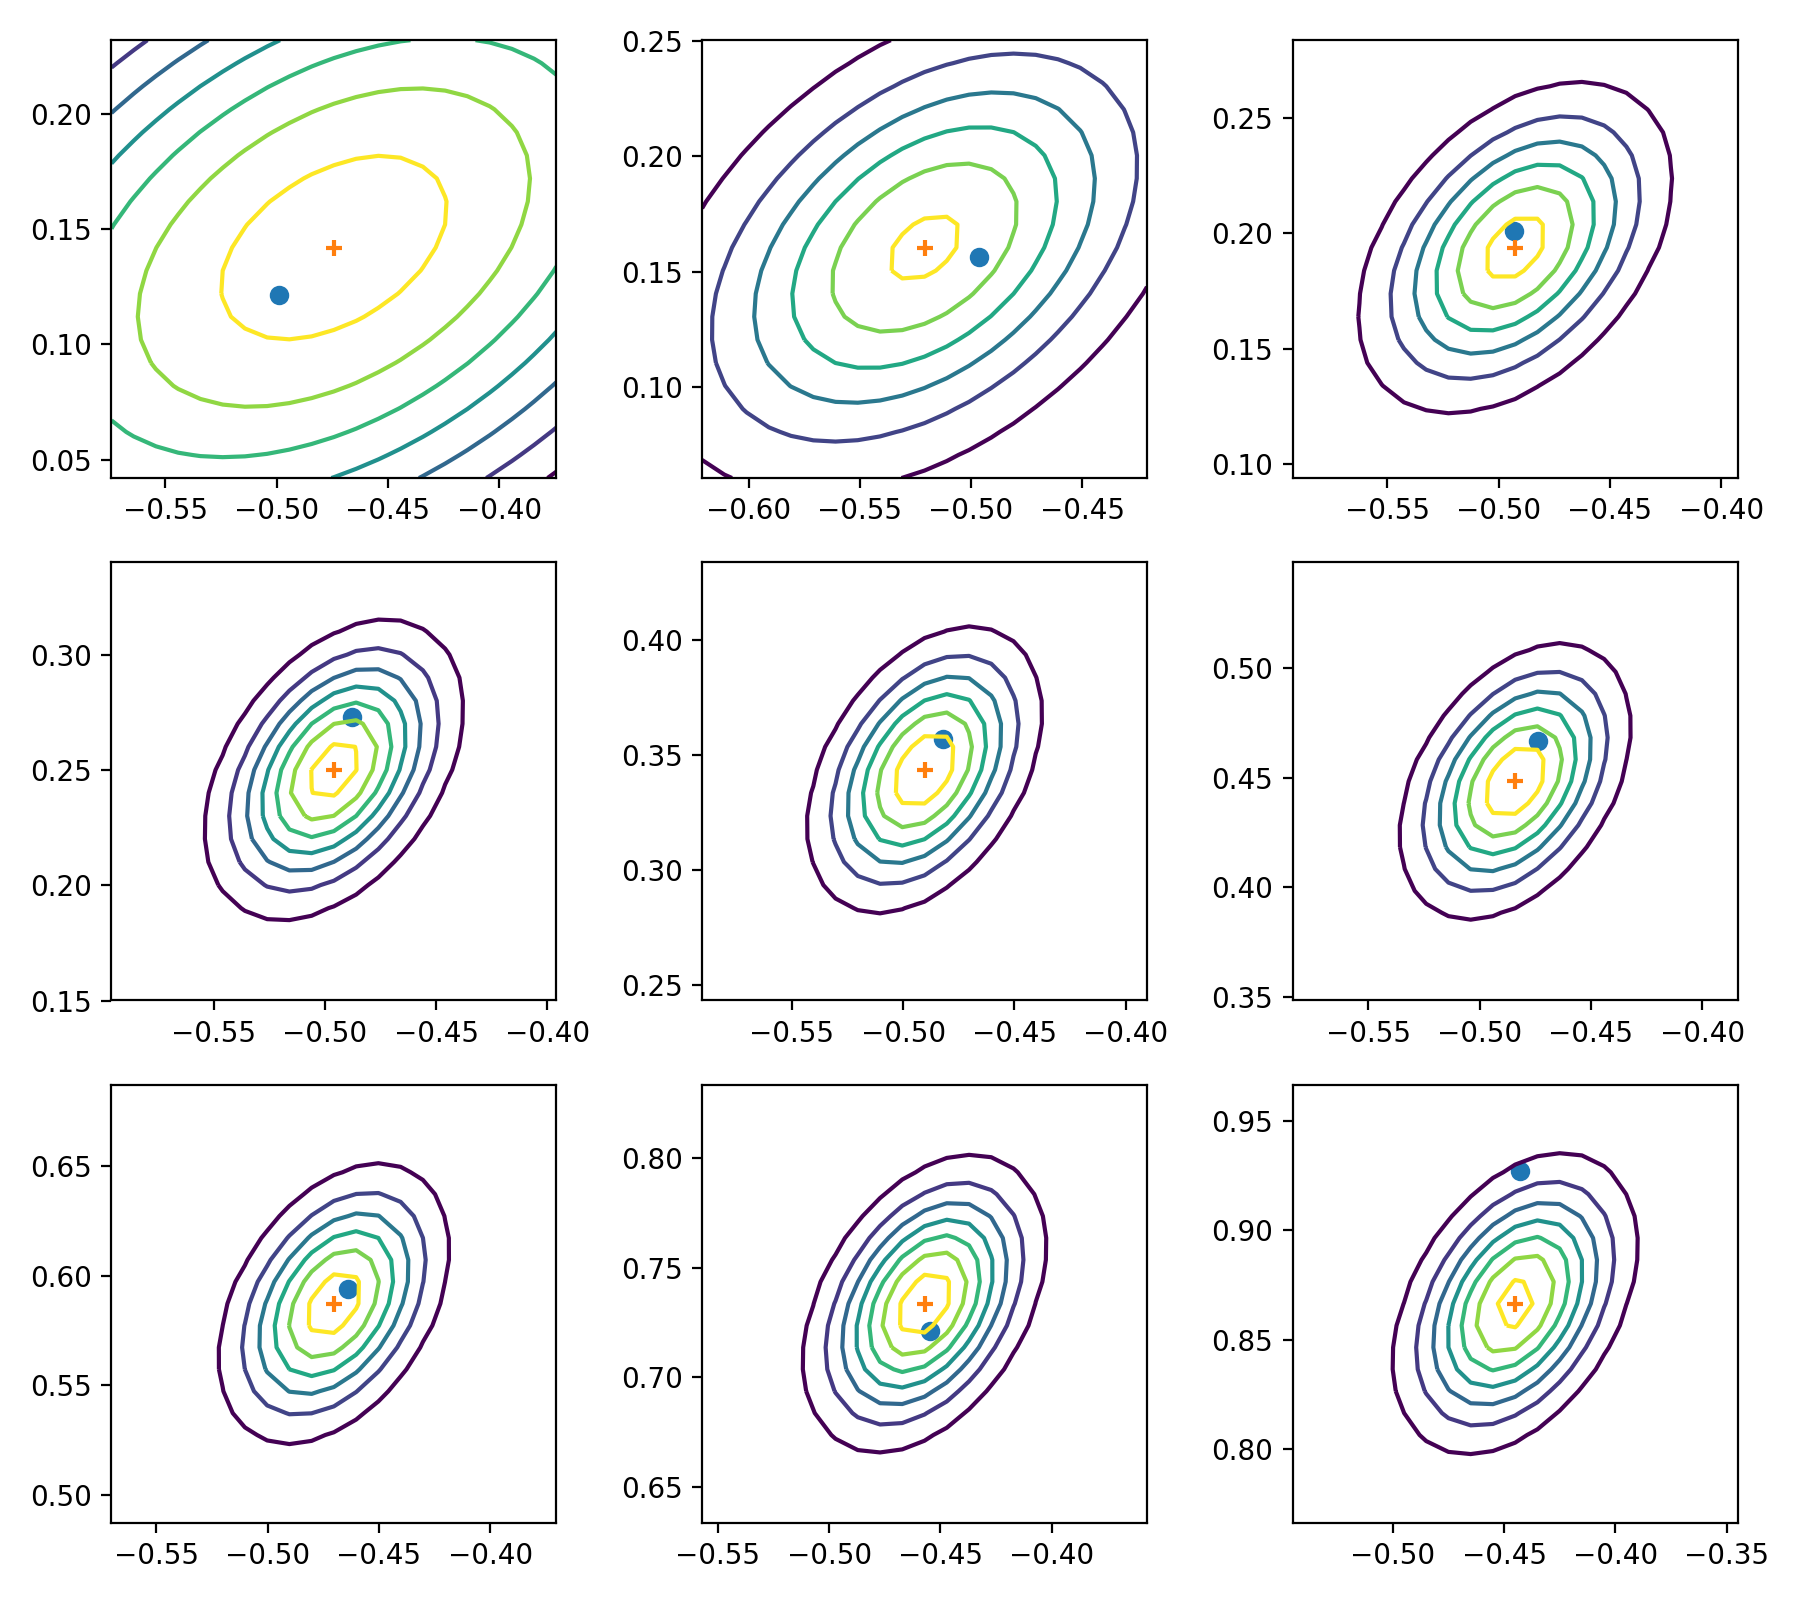

In [167]:
# Draw figure with 9 subplots (3x3) for the predictions on each layer
plt.figure(figsize=(9,8))

for ilay in range(9):
    plt.subplot(3, 3, ilay+1)
    # Construct a gaussian from our prediction
    pred = scipy.stats.multivariate_normal(mus[ilay], covs[ilay])
    
    # Compute values on a grid
    wlow, whigh = mus[ilay] - 0.1, mus[ilay] + 0.1
    phi_grid, z_grid = np.mgrid[wlow[0]:whigh[0]:.01, wlow[1]:whigh[1]:.01]
    pred_grid = pred.pdf(np.dstack([phi_grid, z_grid]))
    
    # Draw the predicted gaussian
    c = plt.contour(phi_grid, z_grid, pred_grid)
    # Draw the actual hit location
    plt.scatter(targets[ilay, 0], targets[ilay, 1])
    # Draw the mean prediction
    plt.scatter(mus[ilay, 0], mus[ilay, 1], marker='+')

plt.tight_layout()

In [203]:
lay.shape

(8,)

In [205]:
mus[:,0].shape

(9,)

<IPython.core.display.Javascript object>


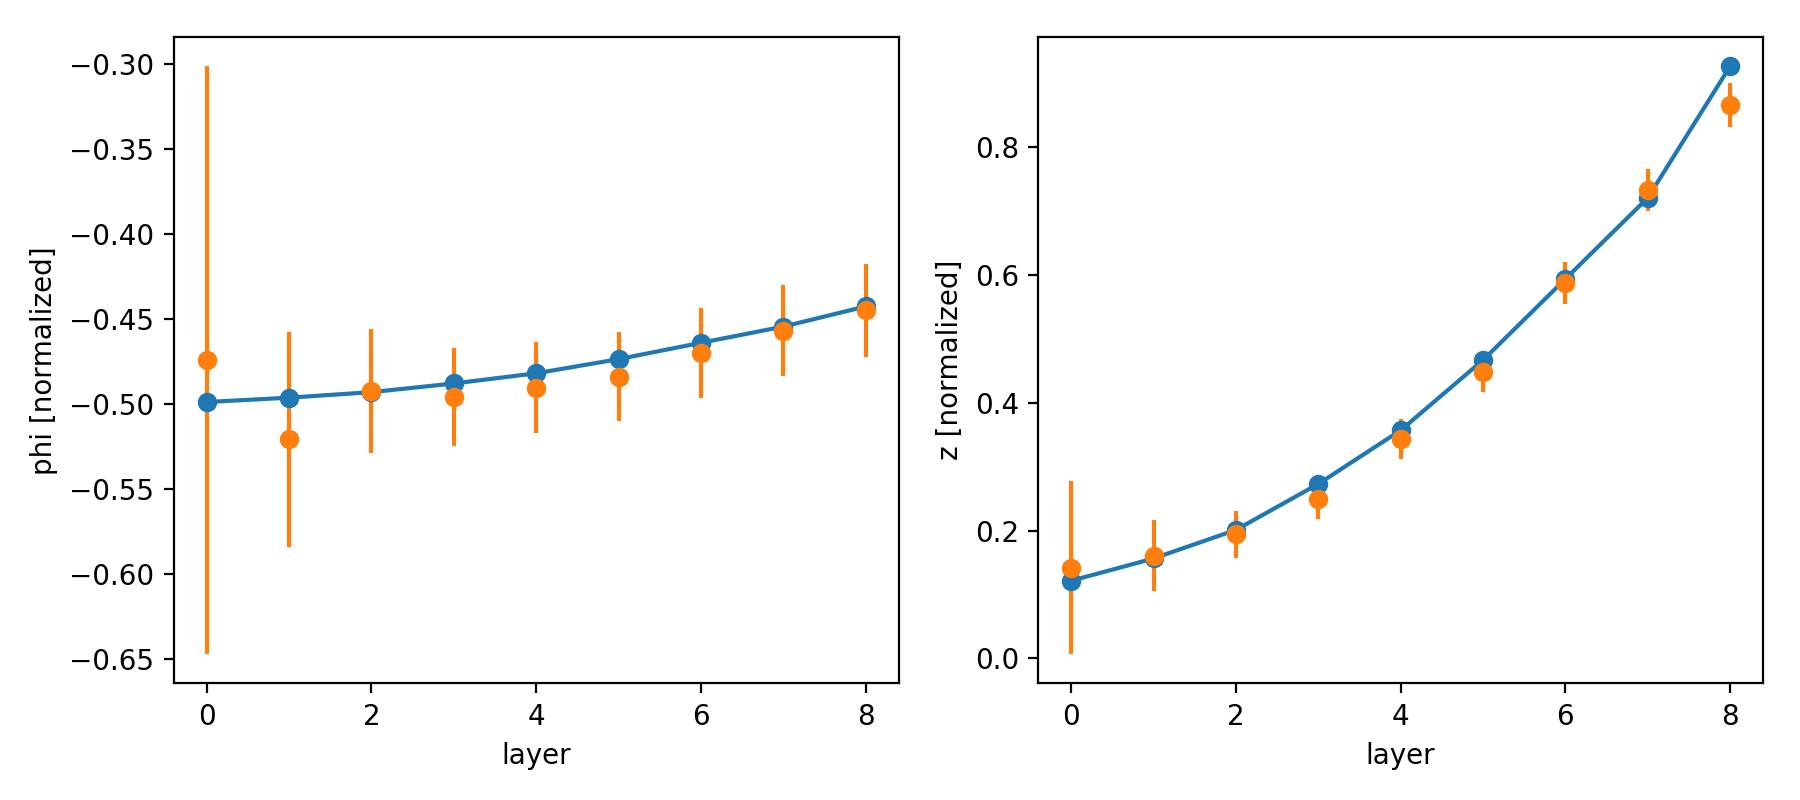

In [219]:
phi_sig = np.sqrt(covs[:,0,0])
z_sig = np.sqrt(covs[:,1,1])
lay = np.arange(9)

# Draw the means first
plt.figure(figsize=(9,4))
plt.subplot(121)
plt.plot(targets[:,0], 'o-')
plt.errorbar(lay, mus[:,0], yerr=phi_sig, fmt='o')
plt.xlabel('layer')
plt.ylabel('phi [normalized]')

plt.subplot(122)
plt.plot(targets[:,1], 'o-')
plt.errorbar(lay, mus[:,1], yerr=z_sig, fmt='o')
plt.xlabel('layer')
plt.ylabel('z [normalized]')

plt.tight_layout()